In [1]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import imutils

# import data handling tools
import zipfile
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder 

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax,SGD , RMSprop ,AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
paths =[]
categories =[]
filenames = os.listdir(r'C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\normal')
for file in filenames:
        category = file.split('.')[0]
        categories.append('0')
        paths.append(os.path.join(r'C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\normal',file))

In [4]:
paths2 =[]
categories2 =[]
filenames2 = os.listdir(r'C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\pneumonia')
for file2 in filenames2:
        category2 = file2.split('.')[0]
        categories2.append('1')
        paths2.append(os.path.join(r'C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\pneumonia',file2))
p = paths+paths2
c = categories+categories2
df = pd.DataFrame({
    'filename': p,
    'category': c
})  

In [5]:
df

,filename,category
0,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,0
1,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,0
2,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,0
3,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,0
4,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,0
...,...,...
534,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,1
535,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,1
536,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,1
537,C:\Users\pirat\Downloads\pneumonia 2-20240125T...,1


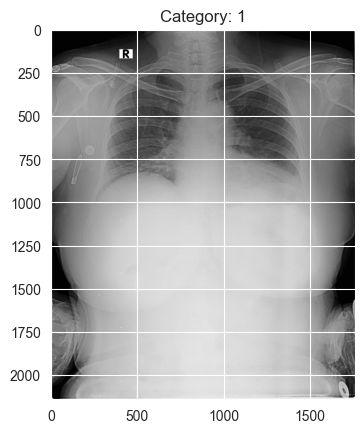

In [6]:
index = np.random.choice(df.index)
filename = df.loc[index, 'filename']
category = df.loc[index, 'category']
img = Image.open(filename)
plt.imshow(img)
plt.title(f'Category: {category}')
plt.show()

In [7]:
def crop_imgs(set_name):
    set_new = []
    for img in set_name:
        img = cv2.imread(img)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
            )
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=1)
        thresh = cv2.dilate(thresh, None, iterations=1)
        # find contours in thresholded image, then grab the largest
        # one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

        # add extreme points
        img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)
        
    return np.array(set_new)

In [8]:
df["image"] = crop_imgs(df["filename"])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (539, 223) + inhomogeneous part.

In [ ]:
df.head(1)

#vgg16

In [21]:
!pip install tensorflow-addons

                                              0.0/719.8 kB ? eta -:--:--
     -                                        30.7/719.8 kB ? eta -:--:--
     -                                        30.7/719.8 kB ? eta -:--:--
     ----                                  81.9/719.8 kB 770.8 kB/s eta 0:00:01
     -------                              143.4/719.8 kB 853.3 kB/s eta 0:00:01
     ----------                             204.8/719.8 kB 1.0 MB/s eta 0:00:01
     ---------------                        286.7/719.8 kB 1.2 MB/s eta 0:00:01
     ---------------                        286.7/719.8 kB 1.2 MB/s eta 0:00:01
     ---------------                      317.4/719.8 kB 895.6 kB/s eta 0:00:01
     ---------------------                  409.6/719.8 kB 1.1 MB/s eta 0:00:01
     --------------------------             501.8/719.8 kB 1.2 MB/s eta 0:00:01
     --------------------------             501.8/719.8 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 719.8/719.8 kB 

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
# change the directory to the dataset in drive folder
main_path= r'C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification'

# Check the folder inside the main path
os.listdir(main_path)

['normal', 'pneumonia']

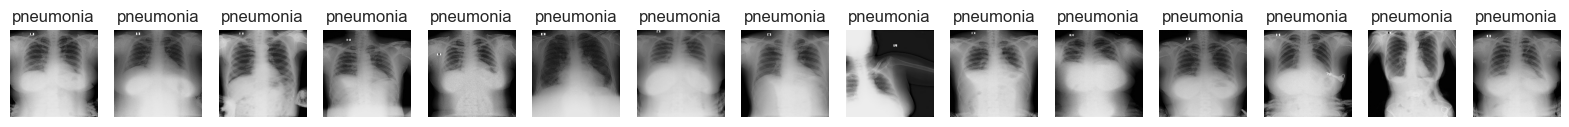

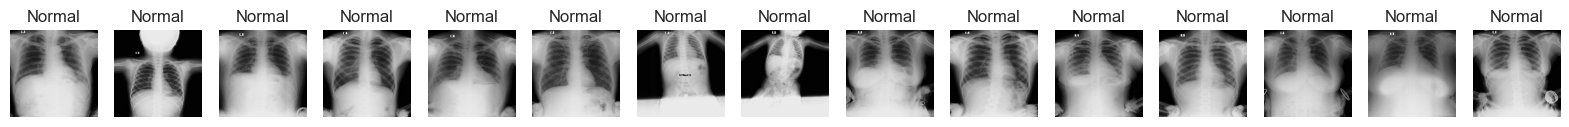

In [27]:
pneumonia = r'C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\pneumonia'
normal =  r'C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\normal'

sub=1
plt.figure(figsize=(20, 10))
for i in range(15):
  plt.subplot(1, 15, sub)
  sub +=1
  plt.imshow(load_img(os.path.join(pneumonia , os.listdir(pneumonia)[i])))
  plt.title('pneumonia')
  plt.axis('off')
plt.show()

sub=1
plt.figure(figsize=(20, 10))
for i in range(15):
  plt.subplot(1, 15, sub)
  sub +=1
  plt.imshow(load_img(os.path.join(normal , os.listdir(normal)[i])))
  plt.title('Normal')
  plt.axis('off')
plt.show()

In [31]:
# Function to calculate the average size for a given folder
def average(folder_path):
    # Get a list of all files in the folder
    all_files = os.listdir(folder_path)

    # Initialize variables to store total width and height
    total_width = 0
    total_height = 0
    num_images = 0

    # Loop through the files, load images, and calculate the total width and height
    for file in all_files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG')):
            img_path = os.path.join(folder_path, file)
            img = Image.open(img_path)
            width, height = img.size
            total_width += width
            total_height += height
            num_images += 1

    # Calculate the average size for the folder
    if num_images > 0:
        average_width = total_width / num_images
        average_height = total_height / num_images

        print(f"Average Width for {folder_path}: {round(average_width)}px x {round(average_height)}px")
    else:
        print(f"No images found with the specified extensions in {folder_path}.")


# Call the function for each folder
average(pneumonia)
average(normal)

Average Width for C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\pneumonia: 223px x 223px
Average Width for C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\normal: 222px x 223px


In [32]:
data = tf.keras.utils.image_dataset_from_directory(main_path, color_mode='grayscale')

Found 538 files belonging to 2 classes.


In [33]:
data_iterator = data.as_numpy_iterator()

# Get one batch from the iterator
batch = data_iterator.next()
len(batch)

2

In [34]:
print('Shape : ',batch[0].shape)

Shape :  (32, 256, 256, 1)


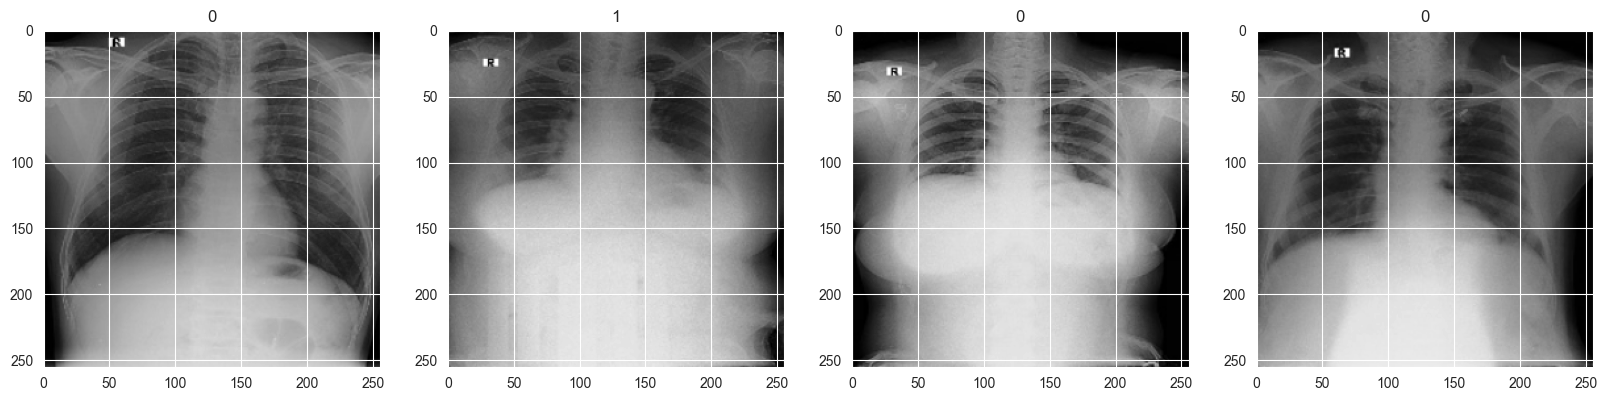

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(int), cmap='gray')
    ax[i].title.set_text(batch[1][i])

In [36]:
data = data.map(lambda x,y: (x/255, y))

In [37]:
len(data)

17

In [38]:
train_size = int(len(data)*.6)
val_size = int(len(data)*.3)
test_size = int(len(data)*.3)

print('Train Batch Size :',train_size)
print('Validation Batch Size :',val_size)
print('Test Batch Size :',test_size)

Train Batch Size : 10
Validation Batch Size : 5
Test Batch Size : 5


In [39]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [40]:
train_batch = tf.data.experimental.cardinality(train).numpy()
val_batch = tf.data.experimental.cardinality(val).numpy()
test_batch = tf.data.experimental.cardinality(test).numpy()

print(f"Total batch in the 'train' dataset: {train_batch}")
print(f"Total batch in the 'val' dataset: {val_batch}")
print(f"Total batch in the 'test' dataset: {test_batch}")

Total batch in the 'train' dataset: 10
Total batch in the 'val' dataset: 5
Total batch in the 'test' dataset: 2


In [41]:
model = Sequential()

model.add(Conv2D(16, (5,5), 3, activation='elu', padding='same', input_shape=(256,256,1)))
model.add(MaxPooling2D())

model.add(Conv2D(8, (5,5), 3, activation='elu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='elu'))
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 86, 86, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 43, 43, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 8)         3208      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 256)               1

In [44]:
%%time

history = model.fit(
    train,
    epochs=20,
    validation_data=val
)

Epoch 1/20
10/10 [==============================] - 2s 81ms/step - loss: 0.5480 - accuracy: 0.7563 - val_loss: 0.5801 - val_accuracy: 0.7937
Epoch 2/20
10/10 [==============================] - 1s 70ms/step - loss: 0.5304 - accuracy: 0.7844 - val_loss: 0.5211 - val_accuracy: 0.7688
Epoch 3/20
10/10 [==============================] - 1s 72ms/step - loss: 0.5092 - accuracy: 0.7781 - val_loss: 0.5091 - val_accuracy: 0.7937
Epoch 4/20
10/10 [==============================] - 1s 71ms/step - loss: 0.4718 - accuracy: 0.8156 - val_loss: 0.5259 - val_accuracy: 0.7937
Epoch 5/20
10/10 [==============================] - 1s 70ms/step - loss: 0.4857 - accuracy: 0.7969 - val_loss: 0.4703 - val_accuracy: 0.7937
Epoch 6/20
10/10 [==============================] - 1s 70ms/step - loss: 0.4974 - accuracy: 0.7688 - val_loss: 0.5391 - val_accuracy: 0.7500
Epoch 7/20
10/10 [==============================] - 1s 72ms/step - loss: 0.4658 - accuracy: 0.7937 - val_loss: 0.4455 - val_accuracy: 0.8188
Epoch 8/20
10

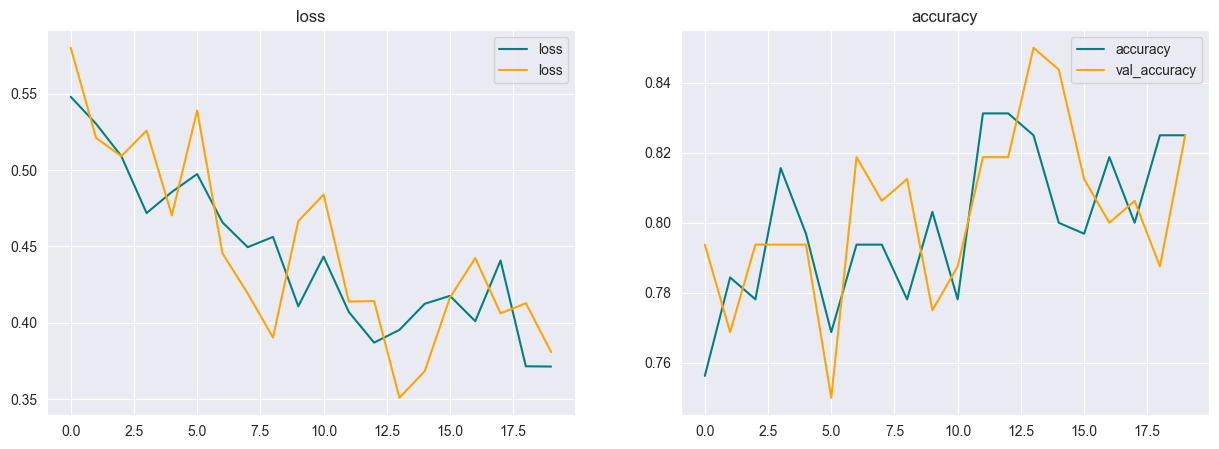

In [45]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='loss')
plt.title('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

In [46]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

1/1 [==============================] - 0s 62ms/step


In [47]:
print(f'Precision : {precision.result()}')
print(f'Recall : {recall.result()}')
print(f'Accuracy : {accuracy.result()}')

Precision : 0.7142857313156128
Recall : 0.5263158082962036
Accuracy : 0.7758620977401733


In [48]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in train.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

print(f'Precision (Train-Set) : {precision.result()}')
print(f'Recall (Train-Set) : {recall.result()}')
print(f'Accuracy (Train-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 26ms/step
Precision (Train-Set) : 0.6170212626457214
Recall (Train-Set) : 0.5370370149612427
Accuracy (Train-Set) : 0.8656250238418579


In [49]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in val.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

print(f'Precision (Validation-Set) : {precision.result()}')
print(f'Recall (Validation-Set) : {recall.result()}')
print(f'Accuracy (Validation-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 25ms/step
Precision (Validation-Set) : 0.7222222089767456
Recall (Validation-Set) : 0.39393940567970276
Accuracy (Validation-Set) : 0.84375


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from numpy.random import seed

In [52]:
seed(25)
tf.random.set_seed(50)

In [53]:
data=[]
paths=[]
labels=[]
for r,d,f in os.walk(r"C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\pneumonia"):
    for file in f:
        if ".jpg" in file:
            paths.append(os.path.join(r,file))
for r,d,f in os.walk(r"C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\pneumonia"):
    for file in f :
        if ".jpg" in file:
            paths.append(os.path.join(r,file))

In [54]:
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(1)

In [55]:
paths = []
for r, d, f in os.walk(r"C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\normal"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))
for r, d, f in os.walk(r"C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\normal"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))
for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(0)
        
data = np.array(data)
data.shape

(1076, 128, 128, 3)

In [56]:
labels=np.array(labels)
labels=labels.reshape(278,1)
print('data shape is:', data.shape)
print('labels shape is:', labels.shape)

ValueError: cannot reshape array of size 1076 into shape (278,1)

In [59]:
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
try:
    from keras.optimizer import Adam
except:
    from tensorflow.keras.optimizers import Adam
    
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

In [60]:
import warnings
warnings.filterwarnings('ignore')

MAIN_DIR = r"C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification"
SEED = 40

In [61]:
os.listdir(MAIN_DIR)

['normal', 'pneumonia']

In [62]:
for dirpath,dirnames,filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

2 directories and 0 images in C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification
0 directories and 425 images in C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\normal
0 directories and 113 images in C:\Users\pirat\Downloads\pneumonia 2-20240125T203918Z-001\classification\pneumonia


In [63]:
# Inspect the raw data before preprocessing
def view_random_image():
    
    subdirs = ['pneumonia/','normal/']
    subdir = np.random.choice(subdirs)
    target_folder = MAIN_DIR + subdir
    
    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = cv2.imread(target_folder+random_image[0])
    plt.imshow(img, cmap="gray")
    plt.axis(False)
    plt.title(img.shape)
    plt.show()

In [64]:
# View Random Image
view_random_image()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\pirat\\Downloads\\pneumonia 2-20240125T203918Z-001\\classificationpneumonia/'